In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  os
import _pickle
import torch

from our_train_edpcnn import main, make_batch_input, get_star_pattern_values, star_pattern_ind_to_mask, smooth_ind
from network import UNet
from snake.snake import SnakePytorch
from data_iterator import Dataset

In [ ]:
args = pd.Series({'train_set_sz' : 1436,
                  'lr' : 1e-4,
                  'delta' : 2,
                  'batch_sz' : 10,
                  'log_freq' : 50,
                  'num_lines' : 50,
                  'radius' : 65,
                  'snake_batch_sz' : 100,
                  'train_eval_freq' : 50,
                  'val_eval_freq' : 50,
                  'sigma_scaling' : 200,
                  'gs_decay' : 0.00,
                  'n_epochs' : 200,
                  'smoothing_window' : 5,
                  'dice_approx_train_steps' : 10,
                  'num_samples' : 10,
                  'use_center_jitter' : True,
                  'theta_jitter' : np.pi,
                  'log_dir' : os.path.join("log/edpcnn/train_set_sz=1436,delta=2,smooth=5,nl=50,theta_jitter=pi"),
                  'seed':0,
                  'weight_decay' : 0.0,
                  'ckpt': '',
                  'sigma': 1.0
                  
                 })

In [ ]:
out = main(args)

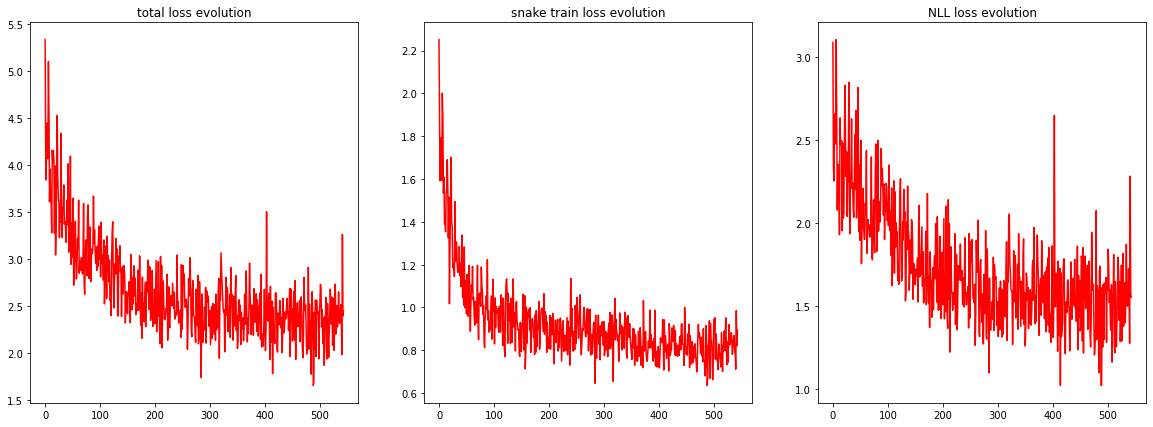

In [ ]:
## loss evaluation during training.
import matplotlib.pyplot as plt

plt.figure(figsize = (20,7))

plt.subplot(131)
plt.plot(out[1],'-r')
plt.title("total loss evolution")

plt.subplot(132)
plt.plot(out[2],'-r')
plt.title("snake train loss evolution")

plt.subplot(133)
plt.plot(out[3],'-r')
plt.title("NLL loss evolution")

plt.savefig("visualize/edpcnn/losses.jpg")

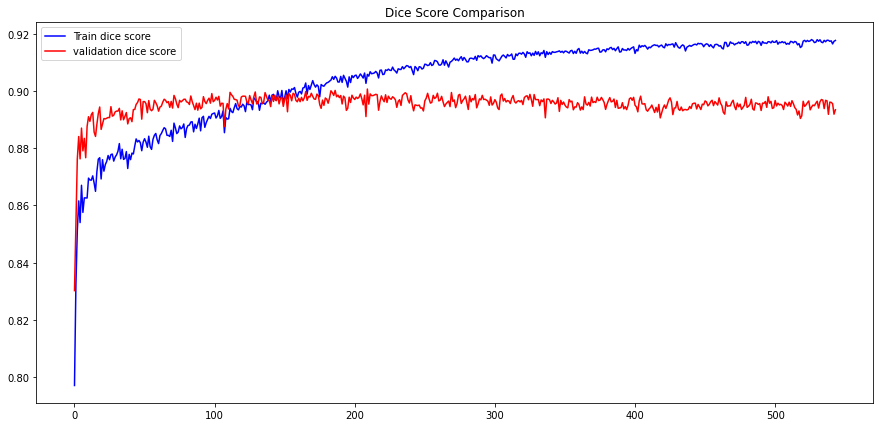

In [ ]:
## Dice Score comparison between train and validation data 
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(out[4],'b')
plt.plot(out[5],'r')
plt.legend(["Train dice score", "validation dice score"])
plt.title("Dice Score Comparison")

plt.savefig("visualize/edpcnn/dices.jpg")

In [ ]:
# loading the saved best model

model_path = "/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/log/edpcnn/train_set_sz=1436,delta=2,smooth=5,nl=50,theta_jitter=pi"
net = UNet(in_dim=1, out_dim=4).cuda()
ckpt_path = os.path.join(model_path, 'best_model.pth.tar')
net.load_state_dict(_pickle.load(open(ckpt_path, 'rb'))[0])

<All keys matched successfully>

In [ ]:
snake_eval = SnakePytorch(args.delta, args.batch_sz, args.num_lines, args.radius)

In [ ]:
num_classes = 1

d = Dataset(train_set_size=args.train_set_sz, num_cls=num_classes)
train = d.train_set
valid = d.test_set

/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/data_2D_size_212_212_res_1.36719_1.36719.hdf5
Keys in dataset:  ['cardiac_phase_test', 'cardiac_phase_train', 'diagnosis_test', 'diagnosis_train', 'height_test', 'height_train', 'images_test', 'images_train', 'masks_test', 'masks_train', 'patient_id_test', 'patient_id_train', 'weight_test', 'weight_train']


In [ ]:
# preparing the predictions for test data.

imgs = valid.images
centers = valid.centers
batch_sz = args.batch_sz
num_lines = args.num_lines
radius = args.radius
smoothing_window=args.smoothing_window

l_pred = []

net.eval()
H, W = imgs.shape[-2:]
if smoothing_window is None:
    smoothing_window = num_lines // 4
with torch.no_grad():
    data_sz = len(imgs)
    n_batches = int(np.ceil(data_sz / batch_sz))
    dice_scores = []
    gs_fixed_shape = torch.zeros(snake_eval.b_sz, num_lines, radius).cuda()
    for j in range(n_batches):
        start = j * batch_sz
        end = (j + 1) * batch_sz
        imgs_batch = imgs[start:end]
        centers_batch = centers[start:end]
        batch_input = make_batch_input(imgs_batch)
        batch_input = torch.cuda.FloatTensor(batch_input)

        gs_logits = net(batch_input)[:, 3, ...]

        # get pixel values on the star pattern
        gs_logits, _, _ = get_star_pattern_values(gs_logits, None, centers_batch, num_lines, radius + 1)
        gs = gs_logits[:, :, 1:] - gs_logits[:, :, :-1]

        # run DP algo
        # can only put batch with fixed shape into the snake algorithm
        gs_fixed_shape.fill_(0)
        gs_fixed_shape[:len(gs), ...] = gs
        ind_sets = snake_eval(gs_fixed_shape).data.cpu().numpy()
        ind_sets = ind_sets[:len(gs), ...]
        ind_sets = np.expand_dims(smooth_ind(ind_sets.squeeze(-1), smoothing_window), -1)
        pred_masks = star_pattern_ind_to_mask(ind_sets, centers_batch, H, W, num_lines, radius)
        for i in range(len(pred_masks)):
            l_pred.append(pred_masks[i].squeeze())

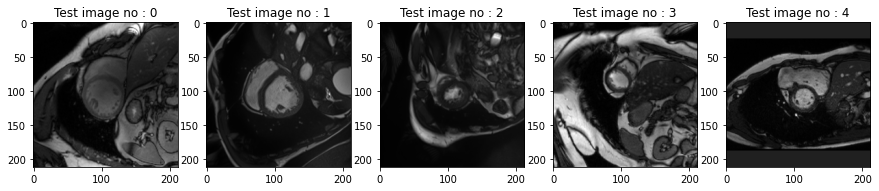

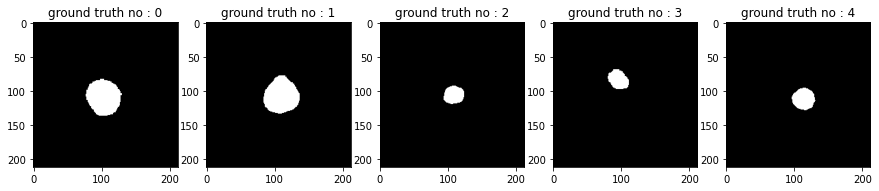

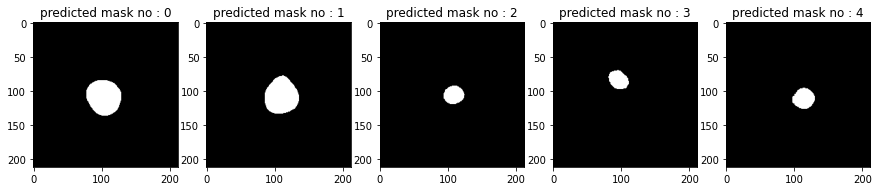

In [ ]:
# Visualizing the predictions for test data set

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    img = valid.images[j].squeeze()
    fig1.add_subplot(1, 5, j+1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Test image no : "+str(j))

plt.savefig("visualize/edpcnn/test_images.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    mask = valid.masks[j]
    fig2.add_subplot(1, 5, j+1)
    plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title('ground truth no : '+str(j))

plt.savefig("visualize/edpcnn/test_masks.jpg")

fig3 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    pred_mask = l_pred[j]
    fig3.add_subplot(1, 5, j+1)
    plt.imshow(pred_mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title("predicted mask no : "+str(j))

plt.savefig("visualize/edpcnn/predicted_masks.jpg")    
    
plt.show()

In [ ]:
## saving the predictions

from PIL import Image

for i,img in enumerate(l_pred):
    im = Image.fromarray((l_pred[i] * 255).astype(np.uint8))
    im.save("EDPCNN_predictions/pred_mask{:03d}".format(i)+".jpg")